<a href="https://colab.research.google.com/github/Zhou-spec/OTC_Marketing_Making/blob/main/actor_critic_test.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import torch
import torch.nn as nn
import numpy as np
import matplotlib.pyplot as plt

In [ ]:
def Stock_Prices_Simulation(T, dt, sigma, S0):
    # T: the total time needed
    # dt: the time interval
    # sigma: the volatility
    # S0: the initial stock price
    # the output is the simulated stock prices in torch tensor

    # let S be on the same device as S0
    N = int(T / dt)
    device = S0.device
    S = torch.zeros(N, device = device)
    S[0] = S0
    for i in range(1, N):
        S[i] = S[i - 1] + sigma * (torch.sqrt(torch.tensor([dt])) * torch.randn(1)).to(device)

    return S


def Market_Order_Generator(bid_vector, ask_vector, A, B, dt):
    # bid_vector: the bid price vector, torch tensor of size N
    # ask_vector: the ask price vector, torch tensor of size N
    # dt: the time interval
    # In this project, we assume that MO intensity lambda = A - B * epsilon

    N = len(A)
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    buy_orders = torch.zeros(N, device = device)
    sell_orders = torch.zeros(N, device = device)

    bid_intensity = A - B * bid_vector
    ask_intensity = A - B * ask_vector
    buy_orders = torch.distributions.poisson.Poisson(bid_intensity * dt).sample()
    sell_orders = torch.distributions.poisson.Poisson(ask_intensity * dt).sample()

    return buy_orders, sell_orders


def DNN_Policy_Stochastic(t, S, q, net, gamma, z, B):
    mean = net.forward(t, S, q)
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    bid_mean = mean[:int(len(mean) / 2)]
    ask_mean = mean[int(len(mean) / 2):]
    covariance_matrix = torch.diag(gamma / (2 * z * B))
    covariance_matrix = covariance_matrix.to(device)
    bid_vector = torch.distributions.multivariate_normal.MultivariateNormal(bid_mean, covariance_matrix).sample()
    ask_vector = torch.distributions.multivariate_normal.MultivariateNormal(ask_mean, covariance_matrix).sample()

    return bid_vector, ask_vector


def Test_Data_Simulation_Stochastic(T, dt, sigma, S0, net, A, B, gamma, z):
    # T: the total time needed
    # dt: the time interval
    # sigma: the volatility
    # S0: the initial stock price
    # net: the neural network that represent the value function
    # this function return the simulated stock prices, buy orders, sell orders, inventory and time for N time steps

    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    N = int(T / dt)
    S = Stock_Prices_Simulation(T, dt, sigma, S0)
    buy_orders = torch.zeros(N, len(A))
    sell_orders = torch.zeros(N, len(A))
    buy_orders = buy_orders.to(device)
    sell_orders = sell_orders.to(device)
    q = torch.zeros(N, device = device)
    t = torch.zeros(N, device = device)
    bid_vectors = torch.zeros(N, len(A))
    ask_vectors = torch.zeros(N, len(A))
    bid_vectors = bid_vectors.to(device)
    ask_vectors = ask_vectors.to(device)
    for i in range(N - 1):
        bid_vector, ask_vector = DNN_Policy_Stochastic(t[i], S[i], q[i], net, gamma, z, B)
        bid_vectors[i] = bid_vector
        ask_vectors[i] = ask_vector
        buy_orders[i], sell_orders[i] = Market_Order_Generator(bid_vector, ask_vector, A, B, dt)
        for j in range(len(A)):
            q[i + 1] += (buy_orders[i][j] - sell_orders[i][j]) * z[j]
        q[i + 1] += q[i]
        t[i + 1] = t[i] + dt

    return S, buy_orders, sell_orders, q, t, bid_vectors, ask_vectors


In [ ]:
def reward(net, S, q, t, buy_orders, sell_orders, T, dt, A, B, gamma, delta, z, Q):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    N = int(T / dt)
    reward = torch.zeros(N, device = device)
    for i in range(N - 1):
        mean = net.forward(t[i], S[i], q[i])
        hold1 = z * buy_orders[i]
        hold2 = z * sell_orders[i]
        # combine hold1 and hold2 into one vector
        hold = torch.cat((hold1, hold2), 0)
        reward[i] = torch.dot(mean, hold)
        reward[i] = reward[i] + (q[i + 1] * S[i + 1] - q[i] * S[i]) - delta * q[i] * q[i]
        reward[i] = reward[i] - (gamma * dt * torch.sum(gamma / (2 * z * B)))
        reward[i] = reward[i] - (gamma * dt * (len(A) * 1.7981798683))

    return reward


def critic_loss(policy_net, value_net, S, q, t, buy_orders, sell_orders, T, dt, A, B, gamma, delta, z, Q):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    r = reward(policy_net, S, q, t, buy_orders, sell_orders, T, dt, A, B, gamma, delta, z, Q)
    loss = torch.zeros(len(r), device = device)
    for i in range(len(r) - 1):
        loss[i] = r[i] * dt + value_net.forward(t[i + 1], S[i + 1], q[i + 1]) - value_net.forward(t[i], S[i], q[i])

    scalar_loss = 0.5 * torch.sum(loss[:-1] ** 2)
    return scalar_loss


def probability(policy_net, S, q, t, bid_vectors, ask_vectors, T, dt, B, gamma, z):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    N = int(T / dt)
    p = torch.zeros(N, device = device)
    for i in range(N - 1):
        mean = policy_net.forward(t[i], S[i], q[i])
        hold1 = bid_vectors[i]
        hold2 = ask_vectors[i]
        hold = torch.cat((hold1, hold2), 0)
        diag = torch.cat((gamma / (2 * z * B), gamma / (2 * z * B)), 0)
        cov = torch.diag(diag)
        p[i] = torch.distributions.multivariate_normal.MultivariateNormal(mean, cov).log_prob(hold)
    return p


def policy_loss(policy_net, value_net, S, q, t, buy_orders, sell_orders, bid_vectors, ask_vectors, T, dt, A, B, gamma, delta, z, Q):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    p = probability(policy_net, S, q, t, bid_vectors, ask_vectors, T, dt, B, gamma, z)
    r = reward(policy_net, S, q, t, buy_orders, sell_orders, T, dt, A, B, gamma, delta, z, Q)
    loss = torch.zeros(len(p), device = device)
    for i in range(len(p) - 1):
        loss[i] = p[i] * (r[i] * dt + value_net.forward(t[i + 1], S[i + 1], q[i + 1]) - value_net.forward(t[i], S[i], q[i]))

    scalar_loss = -torch.sum(loss[:-1]) / len(loss[:-1])
    return scalar_loss

In [ ]:
class ResidualBlock_Conv(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(ResidualBlock_Conv, self).__init__()

        self.conv1 = nn.Conv1d(in_channels, out_channels, kernel_size=3, stride=1, padding=1)
        self.relu = nn.ReLU()
        self.conv2 = nn.Conv1d(out_channels, out_channels, kernel_size=3, stride=1, padding=1)

    def forward(self, x):
        residual = x

        out = self.conv1(x)
        out = self.relu(out)
        out = self.conv2(out)

        out += residual
        out = self.relu(out)

        return out

class ResNet_Conv(nn.Module):
    def __init__(self, intput_size, output_size, input_channels, output_channels, num_blocks, final_act):
        super(ResNet_Conv, self).__init__()

        self.fc = nn.Linear(intput_size, 128)
        self.conv1 = nn.Conv1d(input_channels, output_channels, kernel_size=3, stride=1, padding=1)
        self.relu = nn.ReLU()
        self.final_act = final_act

        self.blocks = nn.ModuleList()
        for _ in range(num_blocks):
            self.blocks.append(ResidualBlock_Conv(output_channels, output_channels))

        self.conv2 = nn.Conv1d(output_channels, input_channels, kernel_size=3, stride=1, padding=1)
        self.fc2 = nn.Linear(128, 256)
        self.fc3 = nn.Linear(256, 128)
        self.fc4 = nn.Linear(128, 64)
        self.fc5 = nn.Linear(64, output_size)

    def forward(self, t, S, q):
        device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
        x = torch.tensor([t, S, q], device = device)
        out = self.fc(x)
        out = out.unsqueeze(0)
        out = out.unsqueeze(0)
        out = self.conv1(out)
        out = self.relu(out)

        for block in self.blocks:
            out = block(out)

        out = self.conv2(out)
        out = self.relu(out)
        out = out.squeeze()
        out = self.fc2(out)
        out = self.relu(out)
        out = self.fc3(out)
        out = self.relu(out)
        out = self.fc4(out)
        out = self.relu(out)
        out = self.fc5(out)
        out = 0.1 * self.final_act(out)


        return out

In [ ]:
T = torch.tensor([1])
dt = torch.tensor([0.01])
S0 = torch.tensor([1])
q = torch.tensor([0])
A = torch.tensor([20, 18, 15, 12, 10, 8])
B = torch.tensor([1, 1, 1, 1, 1, 1])
Q = torch.tensor([300]) # this quantity doesn't matter since I changed the reward function
z = torch.tensor([10, 20, 30, 40, 50, 60])
delta = torch.tensor([0.01]) # this quantity also doesn't matter
gamma = torch.tensor([0.01])
sigma = torch.tensor([0.05])

# use cuda if available
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
T = T.to(device)
dt = dt.to(device)
S0 = S0.to(device)
q = q.to(device)
A = A.to(device)
B = B.to(device)
Q = Q.to(device)
z = z.to(device)
delta = delta.to(device)
gamma = gamma.to(device)
sigma = sigma.to(device)

In [61]:
batch_size = 1
policy_net = ResNet_Conv(3, 12, 1, 2, 2, nn.Sigmoid())
value_net = ResNet_Conv(3, 1, 1, 2, 2, nn.Identity())
policy_net.to(device)
value_net.to(device)
optimizer_policy = torch.optim.Adam(policy_net.parameters(), lr=0.01)
optimizer_value = torch.optim.Adam(value_net.parameters(), lr=0.01)
scheduler_policy = torch.optim.lr_scheduler.StepLR(optimizer_policy, step_size= 3, gamma = 0.95)
scheduler_value = scheduler = torch.optim.lr_scheduler.StepLR(optimizer_value, step_size= 3, gamma = 0.95)
losses_actor_critic = []
p_loss_AC = []
v_loss_AC = []
for epoch in range(50):
  v_loss = 0
  p_loss = 0
  for train in range(batch_size):
    S, buy_orders, sell_orders, q, t, bid_vectors, ask_vectors = Test_Data_Simulation_Stochastic(T, dt, sigma, S0, policy_net, A, B, gamma, z)
    v_loss += critic_loss(policy_net, value_net, S, q, t, buy_orders, sell_orders, T, dt, A, B, gamma, delta, z, Q)
    p_loss += policy_loss(policy_net, value_net, S, q, t, buy_orders, sell_orders, bid_vectors, ask_vectors, T, dt, A, B, gamma, delta, z, Q)
    # when we train the policy net, we need to detach the value net
  loss = v_loss + p_loss
  p_loss_AC.append(v_loss.item())
  v_loss_AC.append(p_loss.item())
  losses_actor_critic.append(loss.item())
  optimizer_policy.zero_grad()
  optimizer_value.zero_grad()
  loss.backward()
  optimizer_policy.step()
  optimizer_value.step()
  print('epoch: ', epoch, 'p_loss: ', p_loss.item() / batch_size)
  print('epoch: ', epoch, 'v_loss: ', v_loss.item() / batch_size)

epoch:  0 p_loss:  200.66481018066406
epoch:  0 v_loss:  3574.55615234375
epoch:  1 p_loss:  386.5017395019531
epoch:  1 v_loss:  9570.1669921875
epoch:  2 p_loss:  1790.2816162109375
epoch:  2 v_loss:  263621.1875
epoch:  3 p_loss:  306.4043273925781
epoch:  3 v_loss:  8840.423828125
epoch:  4 p_loss:  436.5176086425781
epoch:  4 v_loss:  9545.8115234375
epoch:  5 p_loss:  116.09793853759766
epoch:  5 v_loss:  1211.8385009765625
epoch:  6 p_loss:  1601.6717529296875
epoch:  6 v_loss:  165628.84375
epoch:  7 p_loss:  399.0831604003906
epoch:  7 v_loss:  9456.70703125
epoch:  8 p_loss:  103.73396301269531
epoch:  8 v_loss:  1196.462646484375
epoch:  9 p_loss:  333.69415283203125
epoch:  9 v_loss:  8177.01806640625
epoch:  10 p_loss:  521.7219848632812
epoch:  10 v_loss:  16855.82421875
epoch:  11 p_loss:  27.50468635559082
epoch:  11 v_loss:  67.2862319946289
epoch:  12 p_loss:  896.8612670898438
epoch:  12 v_loss:  46644.34375
epoch:  13 p_loss:  426.37091064453125
epoch:  13 v_loss:  

In [65]:
for epoch in range(50):
  v_loss = 0
  p_loss = 0
  for train in range(batch_size):
    S, buy_orders, sell_orders, q, t, bid_vectors, ask_vectors = Test_Data_Simulation_Stochastic(T, dt, sigma, S0, policy_net, A, B, gamma, z)
    v_loss += critic_loss(policy_net, value_net, S, q, t, buy_orders, sell_orders, T, dt, A, B, gamma, delta, z, Q)
    p_loss += policy_loss(policy_net, value_net, S, q, t, buy_orders, sell_orders, bid_vectors, ask_vectors, T, dt, A, B, gamma, delta, z, Q)
    # when we train the policy net, we need to detach the value net
  loss = v_loss + p_loss
  p_loss_AC.append(v_loss.item())
  v_loss_AC.append(p_loss.item())
  losses_actor_critic.append(loss.item())
  optimizer_policy.zero_grad()
  optimizer_value.zero_grad()
  loss.backward()
  optimizer_policy.step()
  optimizer_value.step()
  print('epoch: ', epoch, 'p_loss: ', p_loss.item() / batch_size)
  print('epoch: ', epoch, 'v_loss: ', v_loss.item() / batch_size)

epoch:  0 p_loss:  837.9827880859375
epoch:  0 v_loss:  35870.140625
epoch:  1 p_loss:  541.8975830078125
epoch:  1 v_loss:  19036.421875
epoch:  2 p_loss:  109.07138061523438
epoch:  2 v_loss:  915.8773803710938
epoch:  3 p_loss:  62.45463562011719
epoch:  3 v_loss:  600.7977905273438
epoch:  4 p_loss:  240.1848602294922
epoch:  4 v_loss:  4965.291015625
epoch:  5 p_loss:  974.752685546875
epoch:  5 v_loss:  74479.53125
epoch:  6 p_loss:  106.83808898925781
epoch:  6 v_loss:  1169.09033203125
epoch:  7 p_loss:  182.70919799804688
epoch:  7 v_loss:  3419.67138671875
epoch:  8 p_loss:  779.8150024414062
epoch:  8 v_loss:  47448.015625
epoch:  9 p_loss:  148.09188842773438
epoch:  9 v_loss:  1551.3896484375
epoch:  10 p_loss:  90.87762451171875
epoch:  10 v_loss:  1099.279296875
epoch:  11 p_loss:  167.63160705566406
epoch:  11 v_loss:  1824.012939453125
epoch:  12 p_loss:  192.2477569580078
epoch:  12 v_loss:  3114.809326171875
epoch:  13 p_loss:  185.9816131591797
epoch:  13 v_loss:  3

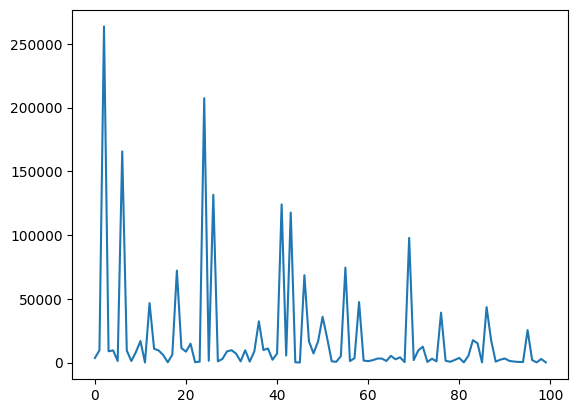

In [66]:
plt.figure()
plt.plot(p_loss_AC)
#plt.ylim(0, 50000)
plt.show()

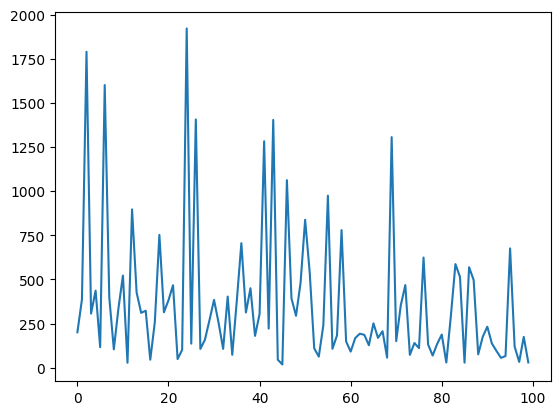

In [67]:
plt.figure()
plt.plot(v_loss_AC)
#plt.ylim(0, 1000)
plt.show()

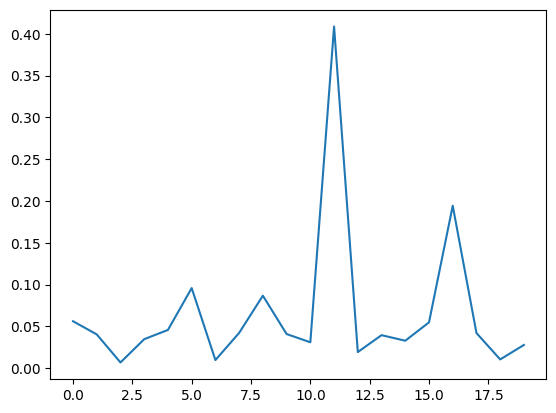

In [69]:
new_x = [v_loss_AC[i] / p_loss_AC[i] for i in range(20)]
plt.figure()
plt.plot(new_x)
plt.show()

In [68]:
import numpy as np
a = np.array(p_loss_AC)
b = np.array(v_loss_AC)
np.save('p_loss_AC.npy', a)
np.save('v_loss_AC.npy', b)

In [ ]:
def final_return(S, q, buy_orders, sell_orders, bid_vectors, ask_vectors, T, dt, z):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    N = int(T / dt)
    final_return = 0
    for i in range(N):
      final_return += torch.sum(z * buy_orders[i] * bid_vectors[i])
      final_return += torch.sum(z * sell_orders[i] * ask_vectors[i])

    final_return += q[-1] * S[-1]
    return final_return

In [ ]:
S_mat = torch.tensor([0.9, 0.92, 0.94, 0.96, 0.98, 1, 1.02, 1.04, 1.06, 1.08]).to(device)
q_mat = torch.tensor([50, 100, 150, 200, 250, 300, 350, 400, 450, 500]).to(device)
t_mat = torch.tensor([0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9]).to(device)
bid_ask_mat = torch.zeros(10, 10, 10, 12).to(device)

for i in range(10):
  for j in range(10):
    for k in range(10):
      mean = policy_net.forward(t_mat[i], S_mat[j], q_mat[k])
      bid_ask_mat[i][j][k] = mean

print(bid_ask_mat)



tensor([[[[0.0666, 0.0793, 0.0633,  ..., 0.0759, 0.0346, 0.0726],
          [0.0796, 0.0926, 0.0732,  ..., 0.0907, 0.0218, 0.0876],
          [0.0884, 0.0976, 0.0812,  ..., 0.0968, 0.0127, 0.0949],
          ...,
          [0.0995, 0.1000, 0.0977,  ..., 0.1000, 0.0006, 0.1000],
          [0.0998, 0.1000, 0.0986,  ..., 0.1000, 0.0003, 0.1000],
          [0.0999, 0.1000, 0.0991,  ..., 0.1000, 0.0002, 0.1000]],

         [[0.0666, 0.0793, 0.0633,  ..., 0.0759, 0.0346, 0.0726],
          [0.0796, 0.0926, 0.0732,  ..., 0.0907, 0.0218, 0.0876],
          [0.0884, 0.0976, 0.0812,  ..., 0.0968, 0.0127, 0.0949],
          ...,
          [0.0995, 0.1000, 0.0977,  ..., 0.1000, 0.0006, 0.1000],
          [0.0998, 0.1000, 0.0986,  ..., 0.1000, 0.0003, 0.1000],
          [0.0999, 0.1000, 0.0991,  ..., 0.1000, 0.0002, 0.1000]],

         [[0.0666, 0.0793, 0.0633,  ..., 0.0759, 0.0346, 0.0726],
          [0.0796, 0.0926, 0.0732,  ..., 0.0907, 0.0218, 0.0876],
          [0.0884, 0.0976, 0.0812,  ..., 0

In [ ]:
rewards_distribution = []
for i in range(100):
  S, buy_orders, sell_orders, q, t, bid_vectors, ask_vectors = Test_Data_Simulation_Stochastic(T, dt, sigma, S0, policy_net, A, B, gamma, z)
  r = final_return(S, q, buy_orders, sell_orders, bid_vectors, ask_vectors, T, dt, z)
  rewards_distribution.append(r.item())

print(rewards_distribution)



[365.6317138671875, 631.2911376953125, -411.2838439941406, 314.7837829589844, 502.7005310058594, -89.25350952148438, 704.9896240234375, 147.32858276367188, 23.75311279296875, 293.04931640625, 1198.3984375, -8.3294677734375, 149.9154052734375, 481.8985595703125, 884.5399169921875, 1287.750732421875, 93.36325073242188, 125.77001953125, 679.68505859375, 532.5247802734375, 883.6685180664062, 94.650390625, 750.58056640625, 685.4037475585938, 238.75010681152344, 643.0679931640625, -34.164306640625, 51.60969543457031, -496.8721618652344, 180.08482360839844, 758.5986328125, 622.6158447265625, 838.0311279296875, -24.505615234375, -609.5699462890625, 919.3276977539062, 808.25341796875, 443.21728515625, 538.6757202148438, 915.9142456054688, -18.4385986328125, 770.92724609375, 224.9269561767578, 646.033447265625, 565.53662109375, 136.7523193359375, 301.0521545410156, -85.08114624023438, 683.2435913085938, -129.231201171875, 937.04443359375, 767.5316772460938, 592.9117431640625, 1084.496337890625, 

In [ ]:
c = np.array(rewards_distribution)
d = bid_ask_mat.cpu().detach().numpy()
np.save('reward_distribution.npy', c)
np.save('bid_ask_mat.npy', d)

In [ ]:
print(d)

[[[[0.06657725 0.07932191 0.06327353 ... 0.0759398  0.03461925
    0.0726464 ]
   [0.07957483 0.09264475 0.07317561 ... 0.09070822 0.02177456
    0.08758014]
   [0.08840434 0.09764078 0.08121473 ... 0.0967972  0.01274876
    0.09493151]
   ...
   [0.09954493 0.0999937  0.09774236 ... 0.09998836 0.00057797
    0.09995962]
   [0.09976692 0.09999808 0.09856408 ... 0.09999625 0.00030412
    0.09998479]
   [0.09988075 0.09999942 0.0990895  ... 0.09999879 0.00015982
    0.09999428]]

  [[0.06657518 0.07932132 0.06327065 ... 0.07593801 0.03461977
    0.0726462 ]
   [0.07957362 0.09264449 0.07317255 ... 0.09070688 0.02177561
    0.08757966]
   [0.08840361 0.09764069 0.0812125  ... 0.09679674 0.01274948
    0.09493131]
   ...
   [0.09954491 0.0999937  0.09774207 ... 0.09998836 0.000578
    0.09995962]
   [0.0997669  0.09999808 0.09856389 ... 0.09999625 0.00030414
    0.09998479]
   [0.09988075 0.09999942 0.09908936 ... 0.09999879 0.00015983
    0.09999428]]

  [[0.06657318 0.07932076 0.0632678 